# Benchmarking pipeline

Enrichment analysis involves combining a statistical enrichment method with a prior knowledge network
that defines sets of features.
A key question is whether the choice of enrichment method or the prior network influences the performance
of the resulting scores.
When perturbation experiments are available, enrichment methods and prior networks can be benchmarked by
evaluating their ability to recover known perturbed regulators.

This notebook demonstrates the use of `decoupler` for benchmarking enrichment methods and prior knowledge
networks using transcription factor (TF) perturbation experiments.

In the first part of this vignette, a toy dataset is employed to benchmark enrichment methods using a
fixed prior knowledge network.
In the second part, single-gene perturbation data from the KnockTF2 database, a literature-curated resource
of perturbation experiments {cite:p}`knocktf`, is used to evaluate various prior knowledge networks.

## Evaluation metrics

To evaluate the enrichment scores obtained from a given network-method combination,
their ability to distinguish perturbed from non-perturbed TFs is
assessed based on the given ground truth.
For instance, TFs identified in the ground truth as positively perturbed
(e.g., overexpressed, phosphorylated) are expected to exhibit positive enrichment scores,
whereas negatively perturbed TFs (e.g., knockdown, knockout) should display negative enrichment scores.
This classification performance can be quantified using three complementary metrics.

### Area Under the Curve

The Area Under the Curve (`auc`) metric includes both the Area Under the Receiver Operating Characteristic Curve (AUROC)
and the Area Under the Precision-Recall Curve (AUPRC).
Each curve is generated by applying varying significance thresholds to the enrichment scores,
and the corresponding area under each curve is computed.
Since AUPRC values are sensitive to class imbalance, which may vary across networks due to differences in TF coverage,
a modified version of AUPRC is used, in which the performance of a random classifier is set to 0.5 {cite:p}`bauprc`.
Similarly, the expected AUROC for a random classifier is also 0.5.

A summary `auc` score can be calculated as the harmonic mean of the AUROC and AUPRC values.

### Precision and Recall (F-Score)

This score first classifies TFs into the following categories:

- True Positive (TP): TF is perturbed, and TF has significant enrichment score in the appropiate direction (+ or -)
- False Positive (FP): TF is not perturbed, but TF has significant enrichment score in any direction
- False Negative (FN): TF is perturbed, but TF does not have significant enrichment score in
  the appropiate direction (+ or -)

Precision and recall are then calculated as follows:

$Precision = TP / (TP + FP)$

$Recall = TP / (TP + FN)$

A summary score is computed as the harmonic mean between the precision and recall values, which is traditionally referred to as the F-score (`fscore`).

### Quantile Normalized Ranks

This score is computed by first ranking the enrichment scores, applying quantile normalization,
and then reversing the values by subtracting them from 1.
As a result, the transformed scores range from 0 to 1, with higher-magnitude enrichment scores
assigned values closer to 1, and lower-magnitude scores closer to 0.

The transformed scores are then grouped into two categories: TFs that belong to the ground truth
(perturbed) and those that do not (non-perturbed).
A one-sided p-value is calculated using the Wilcoxon rank-sum test to assess whether perturbed
TFs tend to have higher quantile-normalized ranks than non-perturbed TFs.
The output includes both the mean reverse-quantile-normalized rank of the perturbed TFs and the
p-value from the statistical test.

A summary `qrank` score is then calculated as the harmonic mean of the mean reverse-quantile-normalized
rank and the −log10(p-value).


## Loading Packages

In [1]:
import numpy as np

import decoupler as dc

## Evaluation of methods

### Loading the dataset

In [2]:
adata, net = dc.ds.toy_bench()
adata

AnnData object with n_obs × n_vars = 30 × 20
    obs: 'group', 'sample', 'source', 'class', 'type_p'

The obtained {class}`anndata.AnnData` consist of log-normalized gene expression values for 20 genes across 30 observations.

We can inspect the cell metadata stored in {attr}`anndata.AnnData.obs`.

In [3]:
adata.obs.head(20)

,group,sample,source,class,type_p
C01,A,S01,"[T1, T2]",CA,1.0
C02,A,S02,"[T1, T2]",CB,1.0
C03,A,S01,"[T1, T2]",CA,1.0
C04,A,S03,"[T1, T2]",CB,1.0
C05,A,S02,"[T1, T2]",CA,1.0
C06,A,S01,"[T1, T2]",CB,1.0
C07,A,S01,"[T1, T2]",CA,1.0
C08,A,S02,"[T1, T2]",CB,1.0
C09,A,S02,"[T1, T2]",CA,1.0
C10,A,S03,"[T1, T2]",CB,1.0


The `source` column contains the ground truth for each observation,
while the `type_p` column indicates the type of perturbation.

In this dataset, group A is expected to exhibit high positive enrichment scores for transcription factors T1 and T2,
whereas group B is expected to do so for T3 and T4.

### Evaluation

To evaluate method performance, enrichment scores are inferred for each method and compared
to the ground truth to compute the three distinct metrics.

In this case, a random baseline method is included to illustrate how a purely random approach compares to the other methods.
This is implemented using the `waggr` method, which supports custom functions for computing enrichment scores.
This functionality also facilitates the testing of new enrichment methods without requiring full implementation from scratch.

It is also possible to specify that a consensus score should be computed based on the results across methods.

In [4]:
def random(x, w):
    """Random baseline method"""
    return np.random.rand(1)[0]


df = dc.bm.benchmark(
    adata=adata,
    net=net,
    kws_decouple={"cons": True, "tmin": 3, "args": {"waggr": {"fun": random}}},
)

In [5]:
df

,method,metric,score
0,ora,auroc,0.665370
1,ora,auprc,0.601464
2,ora,precision,0.400000
3,ora,recall,1.000000
4,ora,1-qrank,0.711667
...,...,...,...
67,consensus,auprc,0.931623
68,consensus,precision,0.000000
69,consensus,recall,0.000000
70,consensus,1-qrank,0.863333


Results across the different metrics can then be visualized.
Here is the plot for the `auc` metric.

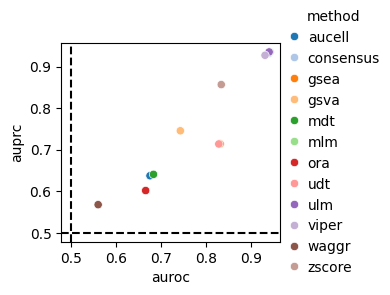

In [6]:
dc.bm.pl.auc(df, hue="method")

The `auc` metric includes both the Area Under the Receiver Operating Characteristic Curve (AUROC) and
the Area Under the Precision-Recall Curve (AUPRC).
Points positioned in the top right of the plot correspond to better performance scores,
while those near the dashed lines indicate lower performance.
The dashed lines represent the expected performance of a random classifier.
As expected, the random method `waggr` performs the worst.

Now, here is the plot for the `fscore` metric.

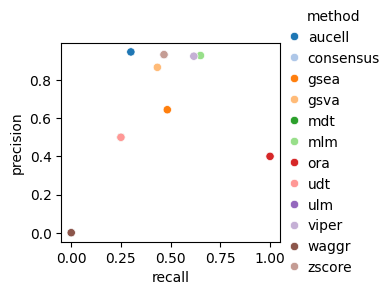

In [7]:
dc.bm.pl.fscore(df, hue="method")

The `fscore` metric includes precision and recall, calculated after filtering for significant enrichment scores.
As with the `auc` metric, points located in the top right of the plot indicate better overall performance.
In this case, certain methods, such as `aucell`, exhibit high precision but low recall,
while others show the opposite trend, such as `ora`.
Methods such as `ulm` and `mlm` achieve a balanced performance with reasonable values for both metrics.
As expected, the `waggr` method, representing a random baseline, performs worse than all other methods.

Finally, here is the plot for the `qrank` metric.

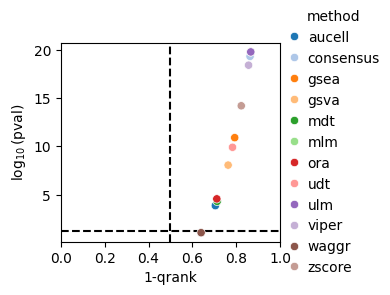

In [8]:
dc.bm.pl.qrank(df, hue="method")

The `qrank` metric comprises two components,
the inverse of the quantile-normalized rank of the ground truth sources (`1-qrank`) and
the log-transformed one-sided p-value obtained from testing for differences between the
ranks of sources belonging to the ground truth and those that do not (`-log10(pval)`).
Higher values of `1-qrank` and of `−log10(pval)` indicate better performance.
Dashed lines represent the expected values for a random method, 0.5 for `1-qrank` and -log10(0.05) for `-log10(pval)`.
As in previous cases, the `waggr` baseline behaves as a random classifier.

These pair of metrics can then be summarized using the harmonic mean between them, generating 3 aggragte metrics.

In [9]:
hdf = dc.bm.metric.hmean(df)
hdf

,method,auprc,auroc,"H(auroc, auprc)",precision,recall,F-score,-log10(pval),1-qrank,"H(1-qrank, -log10(pval))",score
0,aucell,0.637162,0.675000,0.644387,0.947368,3.000000e-01,0.661765,3.876148,0.705000,2.040490,0.462240
1,consensus,0.931623,0.939259,0.933140,0.000000,7.733222e-17,0.000000,19.312727,0.863333,3.661881,0.777099
2,gsea,0.713912,0.830741,0.734573,0.644444,4.833333e-01,0.604167,10.908073,0.793333,3.072753,0.730810
3,gsva,0.745393,0.742407,0.744794,0.866667,4.333333e-01,0.722222,8.068603,0.763333,2.768867,0.686519
4,mdt,0.640447,0.682778,0.648488,0.500000,2.500000e-01,0.416667,4.313612,0.713333,2.146691,0.428243
5,mlm,0.935272,0.941667,0.936544,0.928571,6.500000e-01,0.855263,19.775370,0.866667,3.686995,1.000000
6,ora,0.601464,0.665370,0.613244,0.400000,1.000000e+00,0.454545,4.575803,0.711667,2.193641,0.440749
7,udt,0.713647,0.827870,0.733899,0.500000,2.500000e-01,0.416667,9.910984,0.783333,2.975857,0.658912
8,ulm,0.935204,0.939630,0.936085,0.933333,4.666667e-01,0.777778,19.775370,0.866667,3.686995,0.980342
9,viper,0.927177,0.930556,0.927851,0.925000,6.166667e-01,0.840909,18.404501,0.856667,3.611012,0.975023


And these can also be visualized.

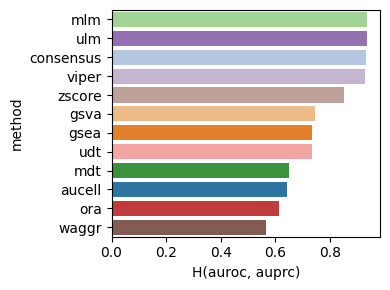

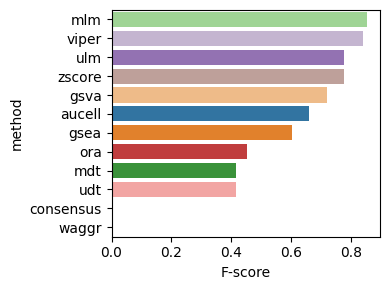

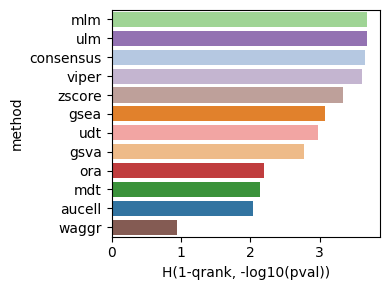

In [10]:
dc.bm.pl.bar(df=hdf, x="H(auroc, auprc)", y="method", hue="method")
dc.bm.pl.bar(df=hdf, x="F-score", y="method", hue="method")
dc.bm.pl.bar(df=hdf, x="H(1-qrank, -log10(pval))", y="method", hue="method")

Finally, the individual summary metrics can be aggregated into a single overall score,
calculated as the quantile-normalized rank of their mean.

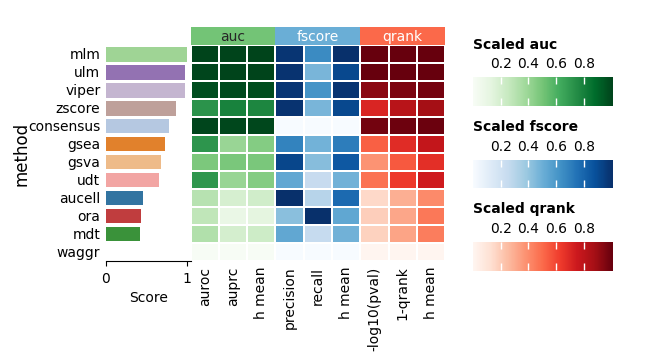

In [11]:
dc.bm.pl.summary(df=hdf, y="method", figsize=(6, 3))

In summary, enrichment methods based on simple linear models, `mlm` and `ulm`,
outperform other approaches in distinguishing perturbed from unperturbed TFs.

These findings are consistent with those reported in the original publication of `decoupler`,
which used real TF perturbation data during evaluation {cite:p}`decoupler`.

## Evaluation of Networks

### Loading the Dataset

In [12]:
adata = dc.ds.knocktf()
adata

AnnData object with n_obs × n_vars = 388 × 21985
    obs: 'source', 'Species', 'Knock.Method', 'Biosample.Name', 'Profile.ID', 'Platform', 'TF.Class', 'TF.Superclass', 'Tissue.Type', 'Biosample.Type', 'Data.Source', 'Pubmed.ID', 'logFC', 'type_p'

The obtained {class}`anndata.AnnData` consist of log2 fold changes for ~22k genes across ~1k experiments.

We can inspect the cell metadata stored in {attr}`anndata.AnnData.obs`.

In [13]:
adata.obs

,source,Species,Knock.Method,Biosample.Name,Profile.ID,Platform,TF.Class,TF.Superclass,Tissue.Type,Biosample.Type,Data.Source,Pubmed.ID,logFC,type_p
DataSet_01_006,PROX1,Homo sapiens,siRNA,Primary lymphatic endothelial cells,GSE12846,GPL570,Homeo domain factors,Helix-turn-helix domains,Foreskin,Primary cell,GEO,18815287,-1.139770,-1
DataSet_01_007,NR2F2,Homo sapiens,siRNA,Primary lymphatic endothelial cells,GSE12846,GPL570,Nuclear receptors with C4 zinc fingers,Zinc-coordinating DNA-binding domains,Foreskin,Primary cell,GEO,18815287,-1.346960,-1
DataSet_01_008,WT1,Homo sapiens,siRNA,PLC/PRF/5,GSE12886,GPL570,C2H2 zinc finger factors,Zinc-coordinating DNA-binding domains,Liver,Cell line,GEO,19190340,-1.114740,-1
DataSet_01_010,TP53,Homo sapiens,shRNA,iPS cells,GSE13334,GPL4133,p53 domain factors,Immunoglobulin fold,Dermal_fibroblasts,Induced pluripotent stem cell,GEO,19668191,-3.137450,-1
DataSet_01_011,TP53,Homo sapiens,siRNA,U251,GSE13991,GPL1426,p53 domain factors,Immunoglobulin fold,Central_nervous_system,Cell line,GEO,19139068,-2.438950,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DataSet_04_032,FUBP1,Homo sapiens,shRNA,HepG2,ENCSR736TAW,-,Others,ENCODE_TF,Liver,Cell line,ENCODE,22955616,-1.270010,-1
DataSet_04_036,SMAD2,Homo sapiens,CRISPR,HepG2,ENCSR036ANR,-,SMAD/NF-1 DNA-binding domain factors,beta-Hairpin exposed by an alpha/beta-scaffold,Liver,Cell line,ENCODE,22955616,-1.559244,-1
DataSet_04_037,SMAD4,Homo sapiens,CRISPR,HepG2,ENCSR700FWD,-,SMAD/NF-1 DNA-binding domain factors,beta-Hairpin exposed by an alpha/beta-scaffold,Liver,Cell line,ENCODE,22955616,-1.404555,-1
DataSet_04_039,SRPK2,Homo sapiens,CRISPR,HepG2,ENCSR929EIP,-,Others,ENCODE_TF,Liver,Cell line,ENCODE,22955616,-1.392551,-1


### Loading the Network

For this example, we will load two prior knowledge gene regulatory networks,
CollecTRI {cite:p}`collectri` and DoRoThEA {cite:p}`dorothea` .

In [14]:
ct = dc.op.collectri()
do = dc.op.dorothea()

In [15]:
ct.head()

,source,target,weight,resources,references,sign_decision
0,MYC,TERT,1.0,DoRothEA-A;ExTRI;HTRI;NTNU.Curated;Pavlidis202...,10022128;10491298;10606235;10637317;10723141;1...,PMID
1,SPI1,BGLAP,1.0,ExTRI,10022617,default activation
2,SMAD3,JUN,1.0,ExTRI;NTNU.Curated;TFactS;TRRUST,10022869;12374795,PMID
3,SMAD4,JUN,1.0,ExTRI;NTNU.Curated;TFactS;TRRUST,10022869;12374795,PMID
4,STAT5A,IL2,1.0,ExTRI,10022878;11435608;17182565;17911616;22854263;2...,default activation


In [16]:
do.head()

,source,target,weight,confidence
0,MYC,TERT,1.0,A
1,FOS,NTS,1.0,A
2,FOS,NTF3,1.0,A
3,FOS,NFKB1,-1.0,A
4,FOS,NEFL,1.0,A


### Evaluation

In this case, two analogous random networks will be generated to serve as random baselines.

In [17]:
rct = dc.pp.shuffle_net(ct)
rdo = dc.pp.shuffle_net(do)

And also each original network but ignoring their mode of regulation (`weight`) information.

In [18]:
unw_ct = ct.drop(columns="weight")
unw_do = do.drop(columns="weight")

To supply multiple networks to the benchmarking function, they must first be organized into a dictionary of networks.
Additionally, only the `ulm` method is used in this case to reduce computational time.

In [19]:
df = dc.bm.benchmark(
    adata=adata,
    net={
        "collectri": ct,
        "dorothea": do,
        "unw_collectri": unw_ct,
        "unw_dorothea": unw_do,
        "r_collectri": rct,
        "r_dorothea": rdo,
    },
    kws_decouple={
        "methods": "ulm",
    },
)

In [20]:
df.head(20)

,net,metric,score
0,collectri,auroc,0.719133
1,collectri,auprc,0.760249
2,collectri,precision,0.007339
3,collectri,recall,0.315412
4,collectri,1-qrank,0.728525
5,collectri,-log10(pval),39.321597
0,dorothea,auroc,0.687706
1,dorothea,auprc,0.721169
2,dorothea,precision,0.010575
3,dorothea,recall,0.359813


Results across the different metrics can then be visualized.
Here is the plot for the `auc` metric.

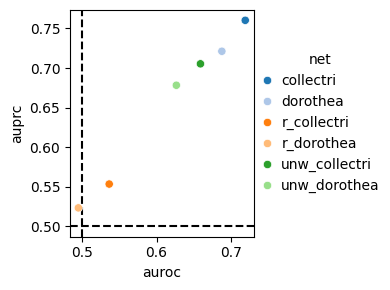

In [21]:
dc.bm.pl.auc(df, hue="net")

Similarly, here is the plot for the `fscore` metric.

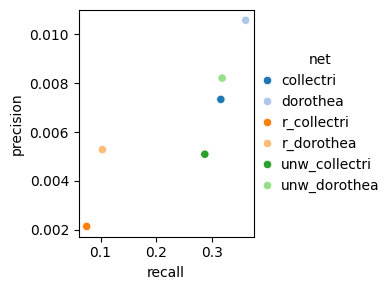

In [22]:
dc.bm.pl.fscore(df, hue="net")

And for the `qrank` metric.

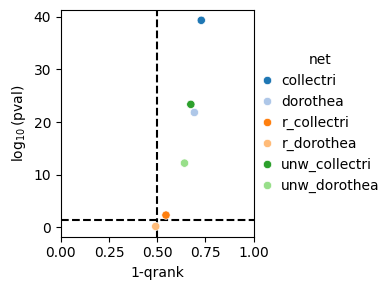

In [23]:
dc.bm.pl.qrank(df, hue="net")

As expected, the random networks are unable to distinguish between perturbed and unperturbed
TFs based on the obtained enrichment scores.

Next, the summary statistics can be generated.

In [24]:
hdf = dc.bm.metric.hmean(df)
hdf

,net,auprc,auroc,"H(auroc, auprc)",precision,recall,F-score,-log10(pval),1-qrank,"H(1-qrank, -log10(pval))",score
0,collectri,0.760249,0.719133,0.751654,0.007339,0.315412,0.009120,39.321597,0.728525,3.391298,1.000000
1,dorothea,0.721169,0.687706,0.714218,0.010575,0.359813,0.013123,21.809839,0.692722,3.073169,0.897834
2,r_collectri,0.553499,0.536420,0.549997,0.002139,0.075269,0.002655,2.311545,0.545284,1.402780,0.361641
3,r_dorothea,0.523412,0.495025,0.517477,0.005282,0.103286,0.006519,0.161909,0.491971,0.187001,0.000000
4,unw_collectri,0.705306,0.658961,0.695523,0.005095,0.286738,0.006340,23.350754,0.674280,3.022308,0.875649
5,unw_dorothea,0.678251,0.626609,0.667253,0.008210,0.317757,0.010196,12.184879,0.641430,2.649298,0.760155


And visualized.

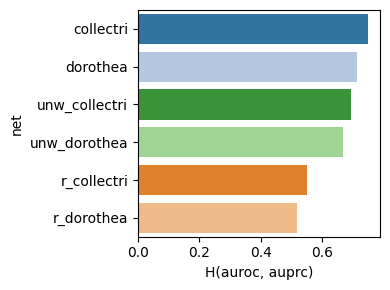

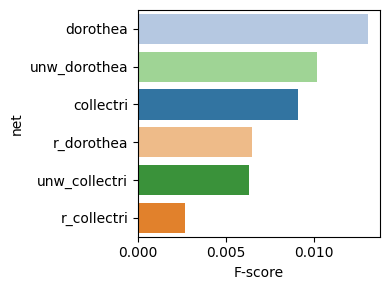

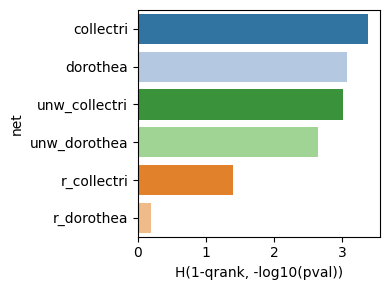

In [25]:
dc.bm.pl.bar(df=hdf, x="H(auroc, auprc)", y="net", hue="net")
dc.bm.pl.bar(df=hdf, x="F-score", y="net", hue="net")
dc.bm.pl.bar(df=hdf, x="H(1-qrank, -log10(pval))", y="net", hue="net")

Finally, the individual summary metrics can be aggregated into a single overall score,
calculated as the quantile-normalized rank of their mean.

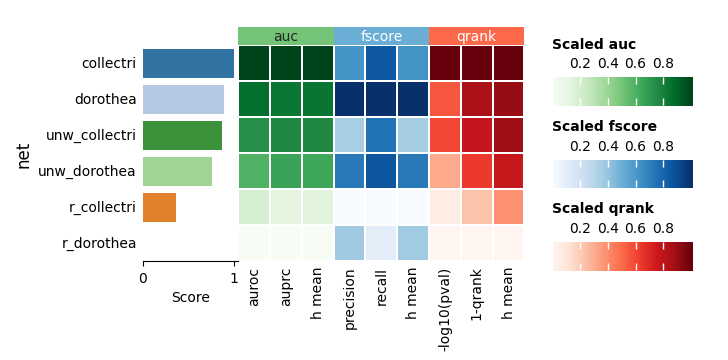

In [26]:
dc.bm.pl.summary(df=hdf, y="net", figsize=(7, 3))

As expected, either removing the mode of regulation (`weight`) or shuffling target
genes leads to a decrease in evaluation performance.